In [8]:
from neural_priors.utils.data import Subject
import pandas as pd
from braincoder.utils import get_rsq

In [2]:
subject = '04'
smoothed = True

sub = Subject(subject)

prf_pars_wide = sub.get_prf_parameters_volume(session=None, smoothed=smoothed, gaussian=True, roi='NPCr',
                                         cross_validated=False, range_n='wide')
prf_pars_narrow = sub.get_prf_parameters_volume(session=None, smoothed=smoothed, gaussian=True, roi='NPCr',
                                            cross_validated=False, range_n='narrow')

prf_pars = pd.concat((prf_pars_wide, prf_pars_narrow), axis=0,
                     keys=['wide', 'narrow'], names=['range_n'])

mask = (prf_pars.unstack(-1)['cvr2'].T > 0.0).any(axis=1)

In [3]:
data = sub.get_single_trial_estimates(session=None, smoothed=smoothed, roi='NPCr',)
behavior = sub.get_behavioral_data(session=None).set_index('range', append=True)

In [4]:
data = pd.DataFrame(data, index=behavior.index)
data = data.loc[:, mask]

In [5]:
from braincoder.models import GaussianPRF
from braincoder.optimize import ParameterFitter
import numpy as np

In [6]:
modes = np.linspace(1, 50, 100, dtype=np.float32)
sigmas = np.linspace(1, 60, 100, dtype=np.float32) / 2.35
amplitudes = np.array([1.], dtype=np.float32)
baselines = np.array([0], dtype=np.float32)

In [9]:

condition = 'wide'

paradigm = behavior.xs(condition, level='range').astype(np.float32)[['n']]

model = GaussianPRF()

optimizer = ParameterFitter(model, data.xs(condition, level='range').astype(np.float32), paradigm.astype(np.float32))

grid_parameters = optimizer.fit_grid(modes, sigmas, amplitudes, baselines, use_correlation_cost=True)

pred = model.predict(paradigm, grid_parameters)
r2 = get_rsq(data.xs(condition, level='range').astype(np.float32), pred)


optimizer.fit(init_pars=grid_parameters, learning_rate=.05, store_intermediate_parameters=False, max_n_iterations=10000,
        fixed_pars=['mu', 'sd'],
    r2_atol=0.00001)

optimizer.fit(init_pars=optimizer.estimated_parameters, learning_rate=.005, store_intermediate_parameters=False, max_n_iterations=10000,
    min_n_iterations=1000,
    r2_atol=0.00001)

Working with chunk size of 13164
Using correlation cost!


  0%|          | 0/1 [00:00<?, ?it/s]

*** Only fitting: ***
 * amplitude
 * baseline
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 211


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 211


  0%|          | 0/10000 [00:00<?, ?it/s]

parameter,mu,sd,amplitude,baseline
source,,,,
8,14.835676,7.369807,0.217200,0.000849
10,-2.660884,15.008098,0.426552,-0.182840
12,12.060912,4.631630,0.303740,-0.100405
13,0.588679,14.096952,0.876056,-0.200444
15,-1.002965,13.444472,0.658228,-0.171571
...,...,...,...,...
709,11.620286,1.421596,0.361391,0.029679
713,11.555078,1.323222,0.401174,0.071685
720,13.875682,0.973021,0.583623,0.207324


In [15]:
from braincoder.optimize import ResidualFitter

In [20]:
stimulus_range = np.arange(10, 40.5, 0.5, dtype=np.float32)
model.init_pseudoWWT(stimulus_range, optimizer.estimated_parameters)
resid_fitter = ResidualFitter(model, data.xs(condition, level='range').astype(np.float32), paradigm.astype(np.float32), parameters=optimizer.estimated_parameters)

omega, dof = resid_fitter.fit()

init_tau: 0.30135685205459595, 1.0296251773834229
USING A PSEUDO-WWT!
WWT max: 53.06509017944336


  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
fisher_information = model.get_fisher_information(stimulus_range, omega, dof)

In [34]:
for key in resid_fitter.fitted_omega_parameters.keys():

    if key == 'tau':
        p = pd.Series(resid_fitter.fitted_omega_parameters[key][0], name=key)
    else:
        p =pd.Series([resid_fitter.fitted_omega_parameters[key]], name=key)

    p.to_csv()

<Axes: xlabel='stimulus'>

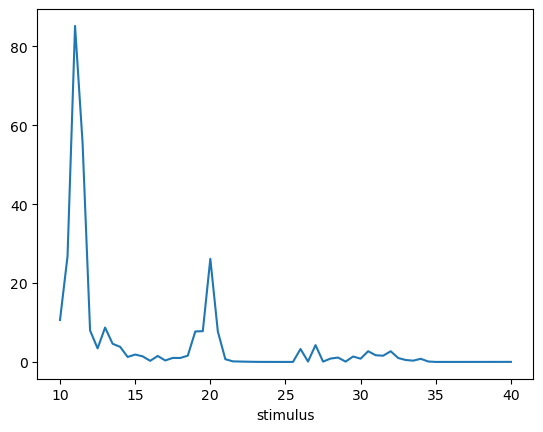

In [23]:
fisher_information.plot()

In [24]:
omega

array([[ 0.51407874,  0.0192326 ,  0.09382778, ...,  0.39760953,
         0.13134259,  0.14594442],
       [ 0.0192326 ,  0.27714717,  0.1449848 , ..., -0.13763638,
         0.04874998,  0.03972684],
       [ 0.09382778,  0.1449848 ,  0.24290548, ...,  0.06583408,
         0.09608401,  0.09957915],
       ...,
       [ 0.39760953, -0.13763638,  0.06583408, ...,  1.1523646 ,
         0.21009591,  0.24962911],
       [ 0.13134259,  0.04874998,  0.09608401, ...,  0.21009591,
         0.32880738,  0.14256664],
       [ 0.14594443,  0.03972683,  0.09957915, ...,  0.24962911,
         0.14256664,  0.28944045]], dtype=float32)